# Dynamical Systems Analysis of a Single Neuron Model

In [2]:
%matplotlib nbagg
import functools
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.integrate as spi
import scipy.optimize as spo
import scipy.interpolate as spolate

In [4]:
# Model for cortical RS pyramidal neuron taken from Izhikevich (2007)
C, k = 100, 0.7
vr, vt, vp = -60, -40, 35
a, b, c, d = 0.03, -2, -50, 100

Istar = k/4 * (vr - vt - b/k)**2

def jump_map(vu):
    return np.array([c,d]) + np.array([0,1]) * vu

def flow_map(I, t, vu):
    v, u = vu
    vdot = (k*(v - vr)*(v - vt) - u + I)/C
    udot = a * (b * (v - vr) - u)
    return np.array([vdot, udot])

def P(t, vu):
    return vu[0] - vp


In [3]:
def poincaré_map(F, x0s, P, mus, tmax, progress_bar=False):
    """
    Given a vector field F on R^n, an (m,n) array of m initial
    conditions x0s, a function P which changes sign when the
    trajectory crosses the Poincaré section, and a vector mu
    of bifurcation parameter values, computes the Poincaré map
    for each combination of IC and bifurcation parameter. 
    Evaluation attempts time out at t = tmax.

    Returns the return time Tret and the Poincaré map Xpcr.
    """
    if progress_bar == True:
        from tqdm import tqdm
    else:
        tqdm = lambda x:x

    P.terminal = True
    mus = np.asarray(mus)
    x0s = np.asarray(x0s)

    Tret = np.zeros((mus.shape[0], x0s.shape[0]))
    Xpcr = np.zeros((mus.shape[0],) + x0s.shape)

    for i, mu in enumerate(mus):
        fun = functools.partial(F, mu)
        for j, x0 in enumerate(x0s):
            out = spi.solve_ivp(fun, (0,tmax), x0, events=P)
            if out.status == 1:
                Tret[i,j] = out.t[-1]
            else:
                Tret[i,j] = np.inf
            Xpcr[i,j,:] = out.y[:,-1]

    return Tret, Xpcr


In [ ]:
# Find the Poincaré map of the neuron

tmax = 10000
u0s = np.linspace(-100, 500, num=51)
mus = np.geomspace(1, 1000, num=101)
x0s = jump_map(np.array([vp + 0*u0s, u0s]).T)

Tret, Xpcr = poincaré_map(flow_map, x0s, P, mus, tmax=tmax, progress_bar=True)

### Saddle-Node Bifurcation
Demonstrates the saddle-node bifurcation of the resting state, which converges with the threshold then eventually disappears as input current increases. For these parameters, this occurs at $I = 51.4\text{pA}$.

<IPython.core.display.Javascript object>


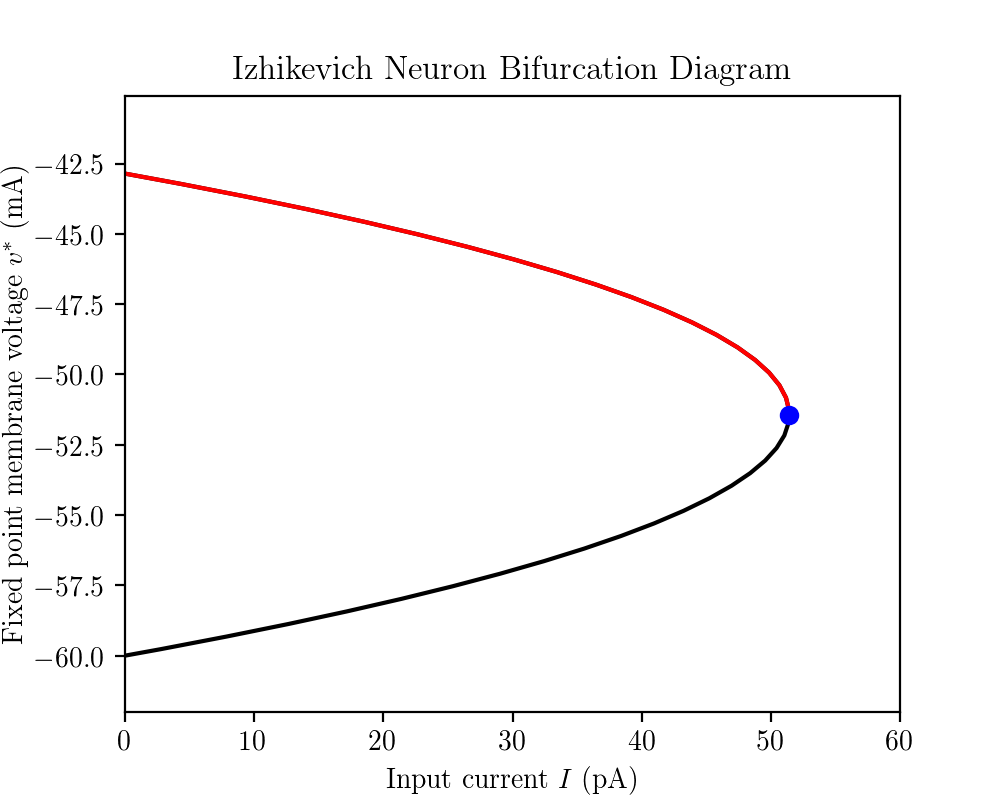

In [10]:
def bifurcation_diagram(f, fx, x, mu):
    "Plot a bifurcation diagram of a 1D dynamical system."
    xx = x.reshape((-1,1))
    mumu = mu.reshape((1,-1))
    fvals = f(xx, mumu)
    fxvals = fx(xx, mumu)
    fvalsP = np.ma.masked_where(fxvals<0, fvals)
    plt.contour(mu, x, fvals, levels=[0], colors='k')
    plt.contour(mu, x, fvalsP, levels=[0], colors='r')
    plt.xlabel('$\mu^*$')
    plt.ylabel('$x^*$')


# Restriction of the system to the u nullcline.
def f(v,I):
    return (k*(v - vr)*(v - vt - b/k) + I)/C

# 1D system derivative wrt v
def fv(v,I):
    return k/C * (2*v - vr - vt - b/k) + 0*I

plt.figure(figsize=(5,4))
bifurcation_diagram(f, fv, np.linspace(-62, -40.1), np.linspace(0,60))
plt.plot(k*(vr - vt - b/k)**2 / 4, (vr + vt + b/k)/2, 'bo')
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('Fixed point membrane voltage $v^*$ (mA)', labelpad=2)
plt.title('Izhikevich Neuron Bifurcation Diagram')

### The I-F Relation
The Poincaré and return-time maps are used to calculate how firing frequency changes with input current, for a constant input from the beginning of time (or after an initial transient). Two particular observations of interest are that (1) these RS neurons appear to exhibit class-I neural excitability, in that their firing frequency increases smoothly and varies over a wide range as input current increases, and (2) the firing frequency appears to follow approximately a 0.75-power law, but trying to reproduce the logarithmic scaling claimed by Izhikevich (2007) requires something a bit weird. 

In [11]:
# Find the fixed points and return times of the Poincaré map.
ustars = np.zeros_like(mus)
tstars = np.zeros_like(mus)

Upcr = Xpcr[:,:,1]
guesses = np.argmin(np.abs(Upcr - u0s), axis=1)

mupoints = np.tile(mus.reshape((-1,1)), (1,len(u0s)))[np.isfinite(Tret)]
u0points = np.tile(u0s.reshape((1,-1)), (len(mus),1))[np.isfinite(Tret)]
uvals = Upcr[np.isfinite(Tret)]
Pinterp = spolate.SmoothBivariateSpline(mupoints, u0points, uvals)

for i,mu in enumerate(mus):
    ustars[i] = spo.fixed_point(lambda u: Pinterp(mu, u), guesses[i])
    
    x0 = jump_map(np.array([[vp, ustars[i]]]))
    tstars[i] = poincaré_map(flow_map, x0, P, [mu], tmax=tmax)[0]

In [12]:
# Find closest linear fit to frequency, i.e. 1/I fit to period.
finites = np.isfinite(tstars)
if np.any(finites):
    alpha = np.poly1d(np.polyfit(mus[mus > 200], 1/tstars[mus > 200], deg=1))
else:
    alpha = lambda mus: mus*0


In [18]:
# Find a fit of the form a*r(I - I0)^k.
I0 = 51.4
def monom(params, mus):
    a, k = params
    out = np.zeros_like(mus)
    out[mus >= I0] = a * (mus[mus >= I0] - I0)**k
    return out

monom_params = spo.fmin(lambda params: np.sum((monom(params, mus[mus > 200])
                                               - 1/tstars[mus > 200])**2),
                        np.array([1e-4, 0.8]))
print(monom_params)

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 81
         Function evaluations: 151
[ 0.00084765  0.75248734]


In [25]:
# Find a logarithmic fit, i.e. a*r(log(I/I0)).
def logmic(params, mus):
    a, I0, k = params
    logs = a * np.log(mus / I0)
    logs *= logs > 0
    logs **= k
    return logs
    
logmic_params = spo.fmin(lambda params: np.sum((logmic(params, mus) - 1/tstars)**2), 
                         np.array([1, I0, 1]))
print(logmic_params)

Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 304
         Function evaluations: 540
[  0.12519306  21.22386384   2.6527666 ]


<IPython.core.display.Javascript object>


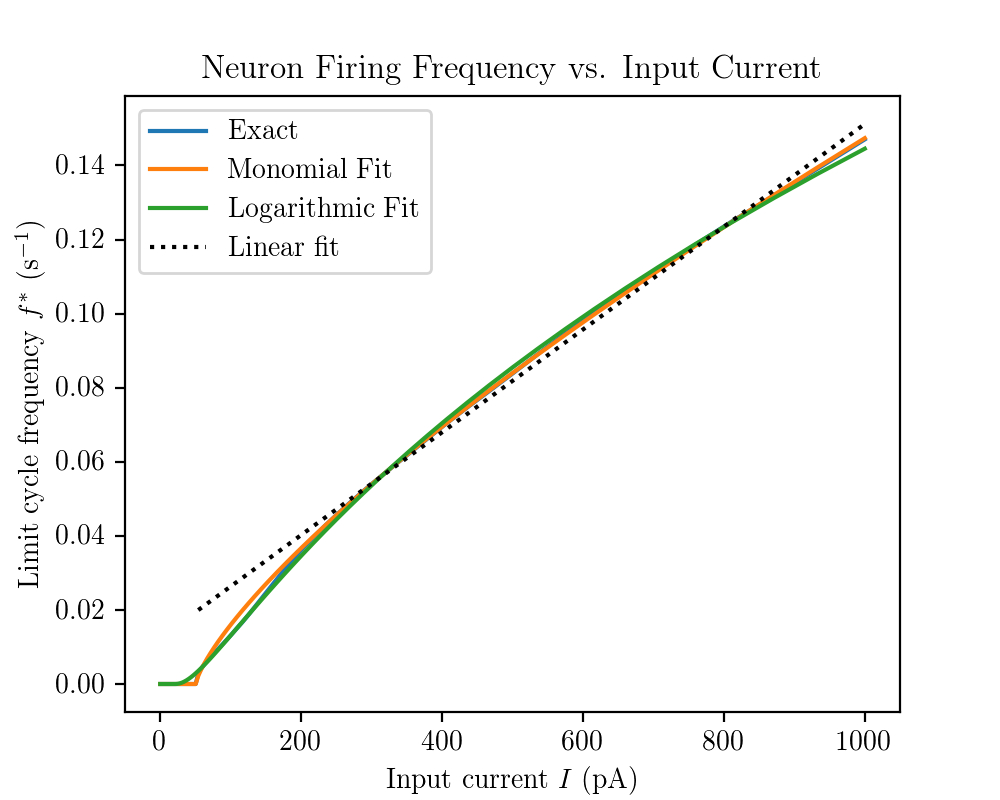

In [26]:
plt.figure(figsize=(5,4))
plt.plot(mus, 1/tstars, label='Exact')
plt.plot(mus, monom(monom_params, mus), label='Monomial Fit')
plt.plot(mus, logmic(logmic_params, mus), label='Logarithmic Fit')
plt.plot(mus[finites], alpha(mus[finites]), 'k:', label='Linear fit')
plt.legend()
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('Limit cycle frequency $f^*$ (s$^{-1}$)')
plt.title('Neuron Firing Frequency vs. Input Current')
xlim = plt.xlim()

<IPython.core.display.Javascript object>


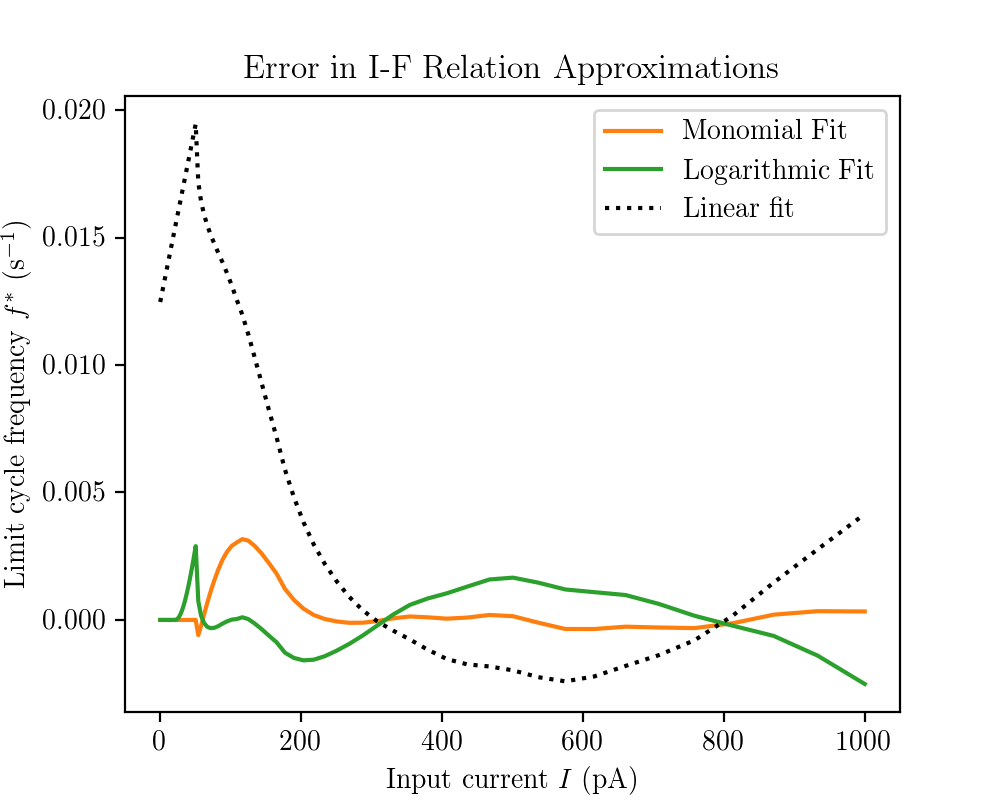

In [30]:
plt.figure(figsize=(5,4))
plt.plot([], []) # use up the blue so colors are consistent
plt.plot(mus, monom(monom_params, mus) - 1/tstars, label='Monomial Fit')
plt.plot(mus, logmic(logmic_params, mus) - 1/tstars, label='Logarithmic Fit')
plt.plot(mus, alpha(mus) - 1/tstars, 'k:', label='Linear fit')
plt.legend()
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('Limit cycle frequency $f^*$ (s$^{-1}$)')
plt.title('Error in I-F Relation Approximations')
xlim = plt.xlim()

### Simulation Across Multiple Firings
Above, we have terminated the simulation immediately when a cell fires. Here, a function is introduced which simulates the cell up to a given time regardless of the number of firings.

In [82]:
def hybrid_sim(flow_map, jump_map, jump_event, t_range, x0, other_events=()):
    """
    Given a hybrid system in the form of the following components:
        flow_map(t, x) -> dx/dt
        jump_map(x) -> x+
        jump_event(t, x) -> 0 within the jump set
        
    And an initial condition in the form of:
        evaluation range t_range = (t_start, t_stop)
        initial condition x0
        
    As well as other_events, an optional list of events to track.
    Note that since these can only occur during flow, their times
    are returned in the continuous (NOT hybrid) time domain.
    
    Returns 
        tout : the evaluation times in a HYBRID time domain
        Xout : the state trajectory corresponding to those times
        tev : the times at which each event occurred (jumps first,
            followed by custom events)
    """
    jump_event.terminal = True
    events = (jump_event,) + other_events
    
    xouts = []
    touts = []
    tev = [[] for _ in events]
    
    i = 0
    jumps = 0
    while True:
        # Compute and save the results until an event or the end.
        res = spi.solve_ivp(flow_map, t_range, x0, events=events)
        
        # Save the latest portion of the state trajectory.
        xouts.append(res.y)
        
        # Save the evaluation times in a hybrid time domain.
        thist = np.vstack((res.t, np.zeros_like(res.t) + jumps))
        touts.append(thist)
        
        # Save all the event times.
        for i, arr in enumerate(res.t_events):
            tev[i] += list(arr)
        
        # Done because of failure or finishing.
        if res.status==0 or res.status==-1:
            break
        
        # Not done, so a jump occurred. Keep jumping until leaving jump set.
        x0 = res.y[:,-1]
        while np.isclose(jump_event(res.t[-1], x0), 0):
            x0 = jump_map(x0)
            jumps += 1
        t_range = res.t[-1], t_range[1]
    
    touts = np.hstack(touts)
    xouts = np.hstack(xouts)
    return touts, xouts.T, tev


<IPython.core.display.Javascript object>


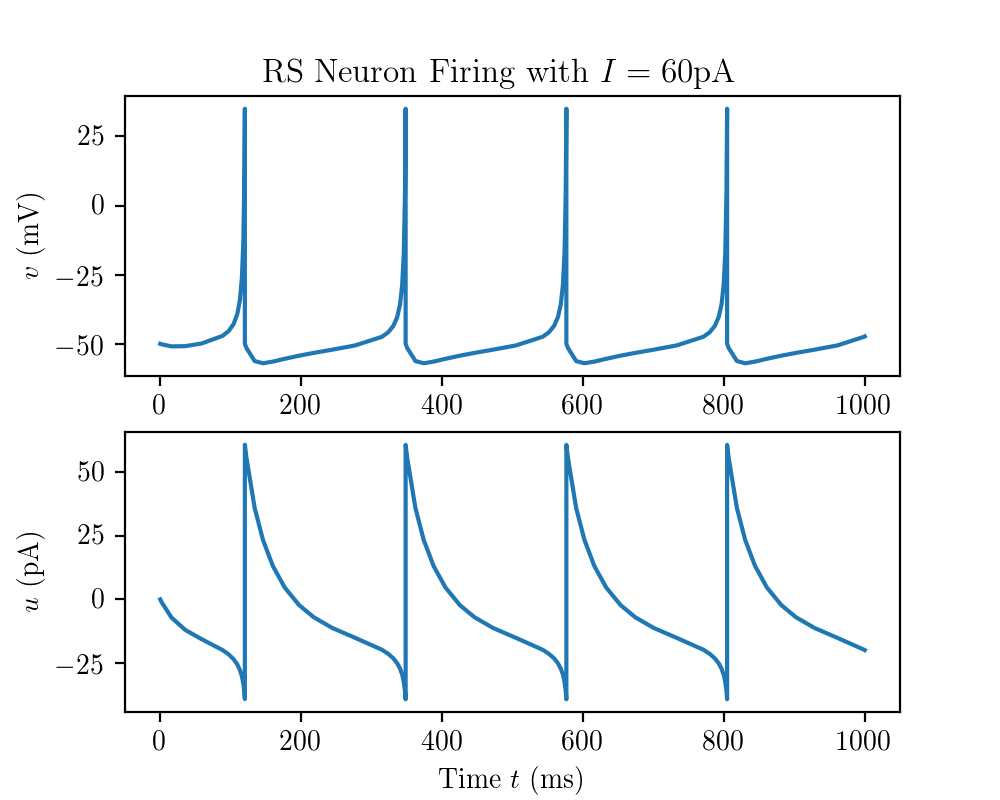

In [92]:
Itest = 60#pA
x0 = np.array([(vr + vt)/2, 0])
the_flow = functools.partial(flow_map, Itest)
tout, xout, tev = hybrid_sim(the_flow, jump_map, P, 
                             (0,1000), x0)

plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout[0,:], xout[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout[0,:], xout[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('RS Neuron Firing with $I = {}\\mathrm{{pA}}$'.format(Itest), y=0.925)

### Comparison of Synapse Models
This section compares a few synapse models by simulating the subthreshold oscillations of a postsynaptic cell whose single presynaptic cell is firing action potentials at a fixed rate of 10Hz, or a 100ms interspike interval. Each synapse model is just a different shape for the postsynaptic current (PSC), which has the side effect of creating a different shape for the postsynaptic potential (PSP). I tried exponential decay, the empirically motivated "alpha function", and the Dirac delta. Graphs are below, of course, but the results are as follows.

Apparently there isn't much difference between $\alpha$ functions and exponentials as synapses, as long as you make sure they have the same *area* rather than the same *peak* as I initially tried. (This means making the peak of the alpha function $e$ times smaller, if you actually go through the integration.)

In both cases, both $u$ and $v$ trajectories are very similar except for a slightly larger peak EPSP for exponentials and $u$ not approaching 0 as closely for alpha functions. These are caused by the same phenomenon: although the functions have the same area, the alpha function is spread out a little more. This matters because the synaptic time constant and the leaky integration time constant have similar order of magnitude. If the synaptic time constant were very small, the other functions would behave the same as the simplest synapse function, the Dirac delta.

In [265]:
# These are kind of based on data from a paper, but 
# the results are the same as long as you stay subthreshold 
# and preserve the order of magnitude of tau_syn.
I_max = 0.65 * C/tau_syn
tau_syn = 11.5


<IPython.core.display.Javascript object>


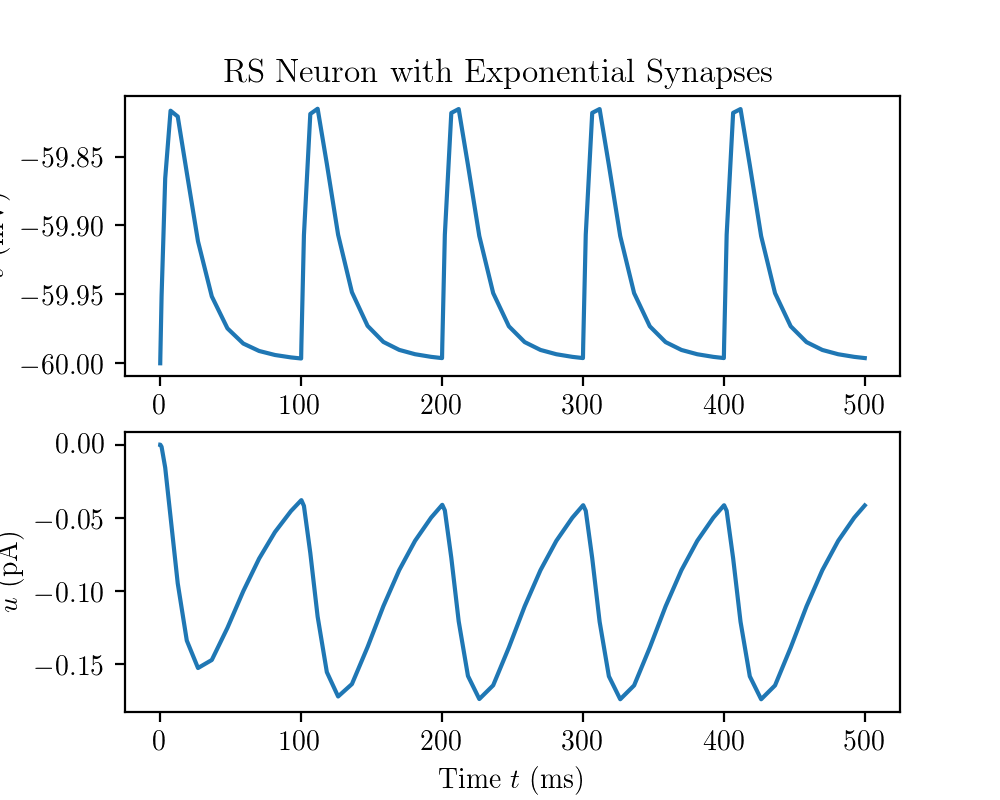

In [266]:
# Typically, in my model, I use these simple exponential synapses.

def the_flow(t, VUI):
    _, _, I = VUI
    VUIdot = flow_map(I, t, VUI[:2])
    return np.append(VUIdot, -I/tau_syn)

x0 = np.array([vr, 0, I_max])
touts, xouts = [], []
for T in range(5):
    tout, xout, _ = hybrid_sim(the_flow, jump_map, P, (T*100,(T+1)*100), x0)
    touts.append(tout)
    xouts.append(xout)
    x0 = xout[-1,:]
    x0[2] += I_max
tout = np.hstack(touts)
xout = np.vstack(xouts)



plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout[0,:], xout[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout[0,:], xout[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('RS Neuron with Exponential Synapses', y=0.925)


<IPython.core.display.Javascript object>


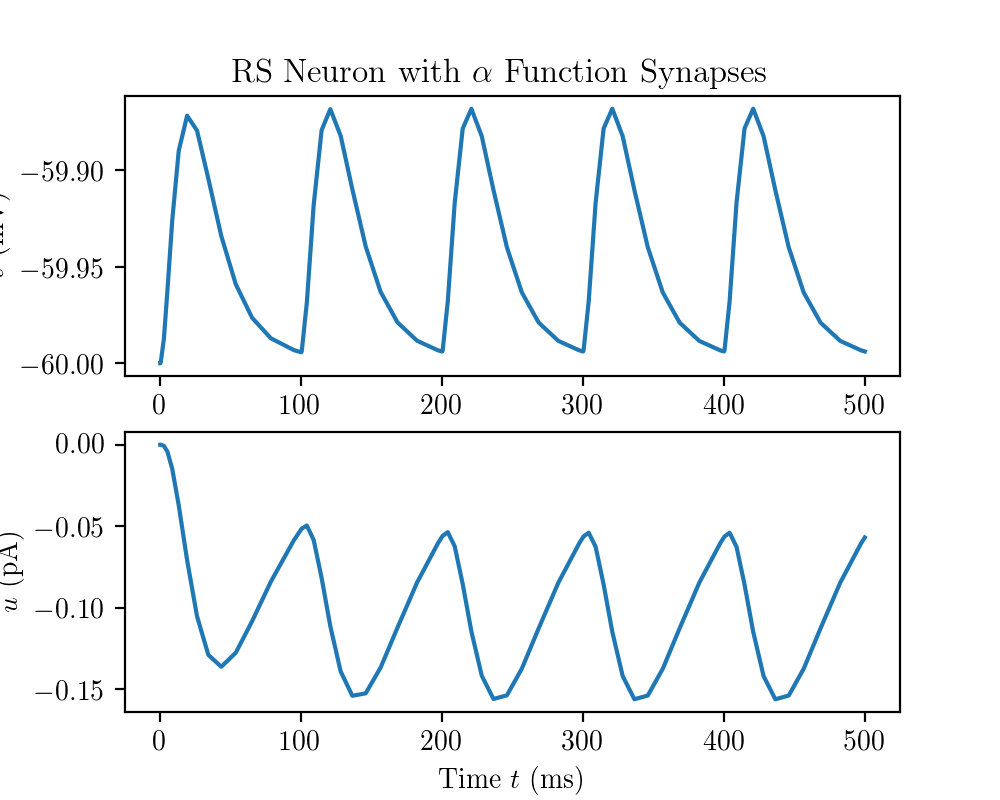

In [267]:
# Here, we test the EPSPs of alpha-function synapses in comparison.

def the_flow(t, VUIJ):
    _, _, I, J = VUIJ
    return np.concatenate([flow_map(I, t, VUIJ[:2]), 
                           [J/tau_syn, 
                            -(I + 2*J)/tau_syn]])

x0 = np.array([vr, 0, 0, I_max])
touts, xouts = [], []
for T in range(5):
    tout, xout, _ = hybrid_sim(the_flow, jump_map, P, (T*100,(T+1)*100), x0)
    touts.append(tout)
    xouts.append(xout)
    x0 = xout[-1,:]
    x0[3] += I_max
tout = np.hstack(touts)
xout = np.vstack(xouts)



plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout[0,:], xout[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout[0,:], xout[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('RS Neuron with $\\alpha$ Function Synapses', y=0.925)


<IPython.core.display.Javascript object>


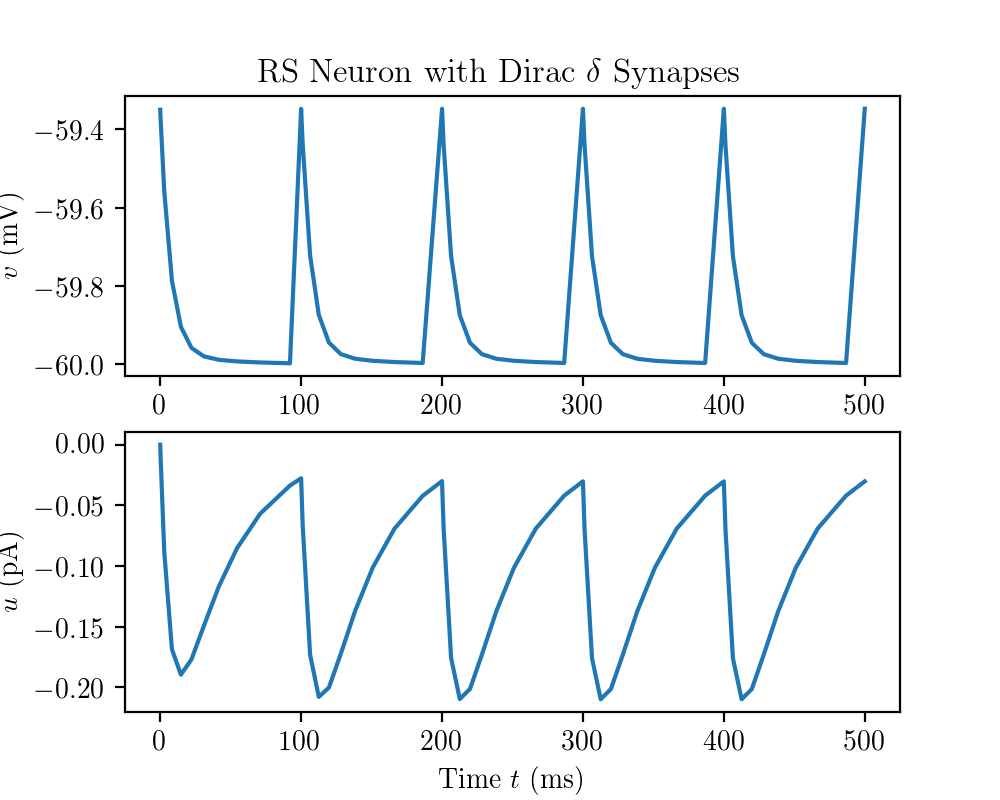

In [268]:
# Here is a simpler synapse model: dirac deltas!

the_flow = functools.partial(flow_map, 0)

delta_V = I_max / C * tau_syn

x0 = np.array([vr + delta_V, 0])
touts, xouts = [], []
for T in range(5):
    tout, xout, _ = hybrid_sim(the_flow, jump_map, P, (T*100,(T+1)*100), x0)
    touts.append(tout)
    xouts.append(xout)
    x0 = xout[-1,:]
    x0[0] += delta_V
tout = np.hstack(touts)
xout = np.vstack(xouts)



plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout[0,:], xout[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout[0,:], xout[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('RS Neuron with Dirac $\\delta$ Synapses', y=0.925)


### Adaption vs. Facilitation and Depression
In biological neurons, several different effects cause variation in the response to a constant input. Spike Frequency Adaption (SFA), which is included in the Izhikevich neuron dynamics through the parameter $d$, is when the effective threshold increases each time a neuron fires. 

There are complementary effects of a pulse train on the postsynaptic side, however, which are not yet modeled. Facilitation occurs when subsequent PSPs increase in size (accumulating presynaptic $\text{Ca}^{2+}$ facilitates synaptic vesicle release), and depression is the reverse (caused by a decrease in available vesicles). 

The effect of that cell is modeled as an injected current with synapse-like properties.
I used alpha-function current because the membrane potential is far from the reversal potential of AMPAR and NMDAR, the typical excitatory channels. This is easier to implement, but constitutes another way in which my modeling of inhibitory synapses is currently broken since the GABAAR reversal potential is -70mV, which is close to the resting potential.

The below is *one* possible model of depression, with parameters set such that because of depression a constant input spike train creates only a single output spike. Of course the remainder of the spikes bring the cell close to threshold, and it probably could be induced to fire an AP by a coincident firing by a fairly weak synapse.

<IPython.core.display.Javascript object>


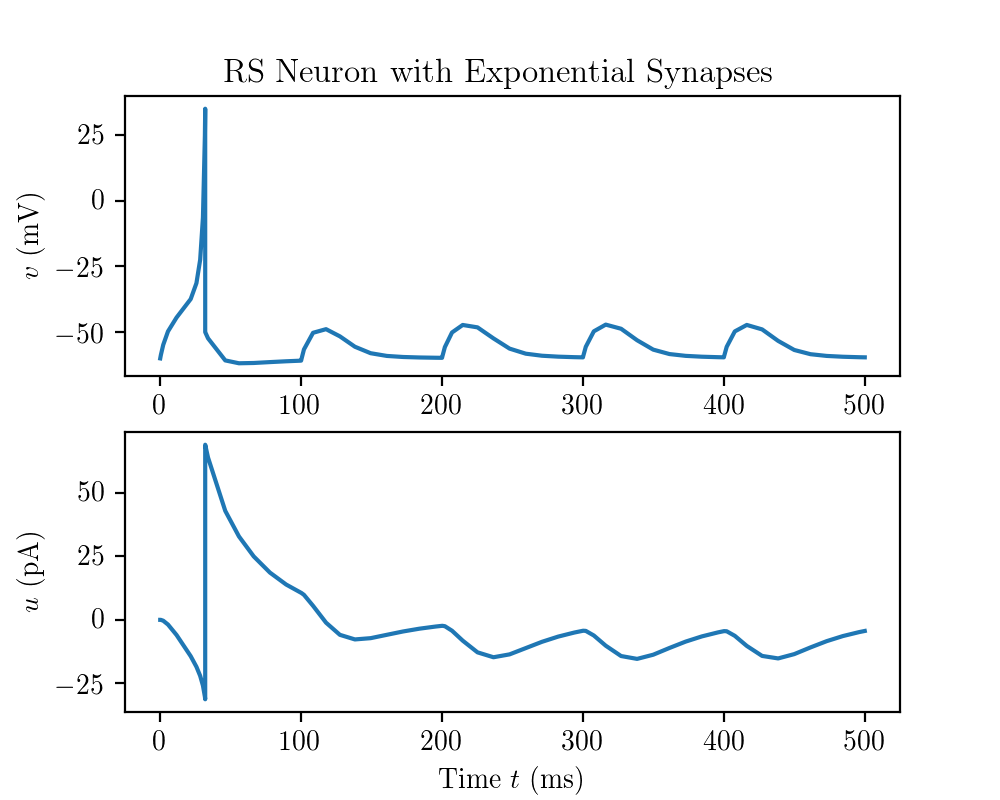

In [257]:
PPR = 0.7
D0 = -np.log(PPR) / np.e
tau_depression = 100

I_trig = 300

def the_flow(t, VUID):
    _, _, I, D = VUID
    VUIDdot = flow_map(I, t, VUID[:2])
    return np.append(VUIDdot, [-I/tau_syn, -D/tau_depression])

def the_jump(VUID):
    _, _, I, D = VUID
    VUIDplus = jump_map(VUID[:2])
    return np.append(VUIDplus, VUID[2:])

x0 = np.array([vr, 0, I_trig, 0])
touts, xouts = [], []
for T in range(5):
    tout, xout, _ = hybrid_sim(the_flow, the_jump, P, (T*100,(T+1)*100), x0)
    touts.append(tout)
    xouts.append(xout)
    x0 = xout[-1,:]
    x0[3] += D0
    x0[2] += I_trig * np.exp(-x0[3])
tout = np.hstack(touts)
xout = np.vstack(xouts)



plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout[0,:], xout[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout[0,:], xout[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('Depression in an RS neuron', y=0.925)

# Bibliography

Izhikevich E. M. (2007). _Dynamical Systems in Neuroscience_. MIT press.
> Source of the model of the cortical RS neuron used here.

Goebel R., Sanfelice R. G., and Teel A. R. (2009). "Hybrid dynamical systems", _IEEE Control Systems Magazine_, vol. 29, no. 2, pp. 28-93.
> Introduces hybrid dynamical systems, in particular
> how to rigorously define time for them on $\mathbb{N}\times\mathbb{R}$
> and how to find limit cycles using a Poincaré map.
